Inizialization of EliCoDe

(without sys.path.insert does not import some submodules)

In [3]:
from EliCoDe_Start import EliCoDe_init
# add path of EliCoDe scripts to python paths
elicode_init = EliCoDe_init("./EliCoDe/src/") #self.path = "./EliCoDe/src/"
elicode_init.start() # sys.path.insert(1, self.path)
# !!!! DO NOT FORGET TO RUN elicode_end() AT THE END OF EXECUTION TO REMOVE PATH

In [4]:
from GED import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

C:\Users\Anton\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from utils import calc_prf05, df_calc_prf05

In [6]:
data = pd.read_csv('speech_small.csv') # whole dataset

In [7]:
GT_df = pd.read_csv('Ground_true.csv') # dataset of manualy checked for errors (contains error free text. Does not contain GT for error detection)
GT_df = GT_df.drop(['Unnamed: 3'], axis=1)
GT_df = GT_df[GT_df['Checked'] == True]

In [22]:
len(GT_df)

35

Load PAISÀ corpus from https://www.corpusitaliano.it/

This is corpus of italian text from web-sites.

Only text from links that contain "it.wiki" will be used, because it's more probable to be from italian Wikipedia and so more probable to be error free. (later called as wiki corpus)

In [8]:
corpus_path = './corpus/paisa.raw.utf8' # PAISÀ corpus
corpus = []

#file_size = os.path.getsize(corpus_path)
pbar = tqdm(total=8332059, unit="lines", unit_scale = True)

with open(corpus_path, "r", encoding="utf-8") as file:
    for i in range(11):
            next(file) # skip line
    exist_line = True
    while exist_line:
        line = file.readline()
        if line.startswith('<text'):
            pbar.update(1)
            temp = line.split(' ')
            line_id = temp[1].split('"')[1]
            line_url = temp[2].split('"')[1]
            text = ""
            next_line = True
            while next_line:
                line = file.readline()
                pbar.update(1)
                if line.startswith('</text>'):
                    next_line = False
                else:
                    text = text + line
            corpus.append({'id': line_id, 'url': line_url, 'text': text})
        else:
            print(line)
            if line == "":
                exist_line = False
print("read done")
file.close()
        
pbar.close()

corpus_df = pd.DataFrame(corpus)

100%|█████████████████████████████████▉| 8.33M/8.33M [00:23<00:00, 351klines/s]



read done


In [9]:
wiki_df = corpus_df[corpus_df['url'].str.contains("it.wiki")]

create bag of 2-grams from wiki corpus

In [8]:
wiki_BOW_n2 = create_BOW_corpus(wiki_df, 2) #tokenizer with re.split(r'\s|([^\w])', text)
wiki_BOW_n2

100%|█████████████████████████████████| 268580/268580 [07:58<00:00, 560.95it/s]


[("l '", 1450528),
 ("dell '", 673738),
 ('. il', 545100),
 ('" ,', 516311),
 ('. la', 486933),
 (', che', 443412),
 (') ,', 378362),
 ("all '", 375915),
 (', e', 369210),
 (') .', 351371),
 (', il', 338406),
 ('. nel', 300368),
 ('\' "', 297487),
 ('" .', 289946),
 ("d '", 283483),
 (', la', 279587),
 (', ma', 259853),
 (', in', 256688),
 ('" (', 234957),
 ('. l', 234130),
 ('per la', 233674),
 ('di un', 224932),
 ("nell '", 214615),
 (', con', 203228),
 ('. in', 199063),
 ('la sua', 198851),
 ('e la', 188209),
 ("un '", 187975),
 ('con la', 187745),
 ('" )', 176393),
 ('il suo', 169504),
 (', "', 168817),
 ('. i', 167104),
 ("dall '", 163291),
 ('" \'', 158297),
 ('con il', 156550),
 ('e il', 152243),
 (', per', 149408),
 ('di una', 145462),
 ('è un', 140634),
 (', a', 139465),
 ('per il', 137693),
 ('. le', 136164),
 ('l ’', 133762),
 ('collegamenti esterni', 131609),
 (') e', 130155),
 (', è', 129541),
 (', l', 127072),
 ('di "', 127044),
 ('è stato', 126169),
 (', nel', 123708),
 

wiki_BOW_n2[10000000] # top 50% -> ("' fisiognomonica", 1) -> to remove!

wiki_BOW_n2[5000000] # top 25% -> ('ripetuti danneggiamenti', 2) -> to remove!

wiki_BOW_n2[2000000] # top 10% -> ('allora nessuna', 7)

wiki_BOW_n2[200000] # top 1% -> ('lenin e', 100)

-----------------------------------------------------------------------------------

In [9]:
wiki_BOW_n2[0]

("l '", 1450528)

Following Histogram rapresent how top 10 elements in Bag of 2-grams are significally bigger then the element from top 10%. This makes impossible to use method of error detection or correction based on frequency and distance by following formula: 

$P(c)/(d(w|c) + 1)$

where $P(c)$ is absolute frequency of candidate n-gram $c$ in BOW and $d(w|c)$ is levinstain distance between original n-gram $w$ and candidate $c$ from BOW. $+ 1$ in $d(w|c) + 1$ used to remove cases when distance is 0 (n-gram is in BOW).

In almost every case frequency of $c_1$ (wiki_BOW_n2[0]) is significally bigger then distance between $w$ and $c_1$ and $c_1$ have bigger score then any other candidate.

3 possible workarounds I can see:

1) Modify function that makes distance more significant then frequency
2) Normalize frequencies (how? will it help? Min-Max won't help (disproportion will stay). Based on mean and std. variation -> what values to take?)
3) Use only search in BOW (when distance == 0) as error detection. Because I limit BOW up to top 10% most low frequent errors are not in BOW of the search, but high frequent will be (may exist FN ($w$ is marked as correct, but it's wrong)). Additionaly some almost never used, but correct, n-grams may not be in top 10%, so FP ($w$ is marked as error, but it's correct) may be also present.

In [8]:
for_hist = wiki_BOW_n2[0:10] + [wiki_BOW_n2[2000000]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(for_hist[i][1])

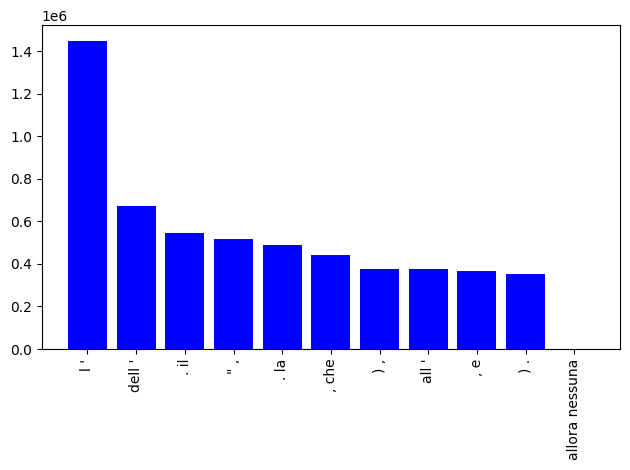

In [9]:
indices = np.arange(len(for_hist))
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

Create bag of 2-gram with Spacy tokenizer

#!!!!!!! run of this cell require few hours !!! load file of this result if you have it

s_wiki_BOW_n2 = create_s_BOW_corpus(wiki_df, 2) # !!! require few hours !!! load file of this result if you have it

#Save result of previous cell to file

with open("s_wiki_BOW_n2.txt", "w", encoding="utf-8") as file:

    for tup in s_wiki_BOW_n2:
    
        file.write(tup[0]+'| | |'+str(tup[1])+"\n")
        
    file.close()

In [11]:
# !!!!!!!!! load s_wiki_BOW_n2 from file
s_wiki_BOW_n2 = []
lines = []
with open("s_wiki_BOW_n2.txt", "r", encoding="utf-8") as file:
    lines = [line.rstrip() for line in file]
    
ready = True

for i in range(len(lines)):
    if lines[i] != '':
        st = lines[i]
        if '| | |' not in st and '| | |' in lines[i+1]:
            i+=1
            st = st + "\n" + lines[i]
            ready = True
        elif '| | |' not in st and '| | |' not in lines[i+1]:
            i+=1
            st = st +"\n"+ lines[i]
            ready = False
        elif '| | |' in st:
            ready = True
        else:
            print("FIX CODE!!!")
            raise Exception("incorrect if statement")
        if ready == True:
            try:
                spl = st.rsplit('| | |', 1)
                s_wiki_BOW_n2.append((spl[0],spl[1]))
            except:
                print('Error: ', i, st)

s_wiki_BOW_n2[2000000] -> ('deliberato tentativo', '7')

detection by: if $w$ in bow

In [12]:
# tokenizer by re.split(r'\s|([^\w])', text)
GT_df['2c_catch'] = None
GT_df['2c_extra'] = None
GT_df['2c_miss'] = None

#tokenizer by spacy
GT_df['2sc_catch'] = None
GT_df['2sc_extra'] = None
GT_df['2sc_miss'] = None

In [13]:
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    result = two_gramm_corpus(text, wiki_BOW_n2[:2000000])
    check = gt_bio(each_word(gt_text), each_word(text))
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'2c_catch'] = catch
    GT_df.loc[index,'2c_extra'] = extra
    GT_df.loc[index,'2c_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_corpus')
    
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    text_words = []
    doc = nlp(text)
    for token in doc:
        text_words.append(token.text)

    check = gt_bio(correct_text_words, text_words)
    
    result = two_gramm_corpus(text, s_wiki_BOW_n2[:2000000])
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'2sc_catch'] = catch
    GT_df.loc[index,'2sc_extra'] = extra
    GT_df.loc[index,'2sc_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_spacy_corpus')



100%|██████████████████████████████████████████| 35/35 [33:16<00:00, 57.03s/it]

34 two_gramm_spacy_corpus


In [39]:
GT_df

,OCR_Text,Ground_True,Checked,2c_catch,2c_extra,2c_miss,2sc_catch,2sc_extra,2sc_miss
0,"MORINI, Segretmio, legge: (C Per gli intervent...","MORINI, Segretario, legge: « Per gli intervent...",True,2,6,12,5,11,26
1,GIORGIO NEBBIA. Solo per ricordare che anche i...,GIORGIO NEBBIA. Solo per ricordare che anche i...,True,2,2,0,2,1,0
2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",True,0,5,2,1,7,1
3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,True,0,2,2,1,4,2
4,due controllate dal gruppo FIAT tramite la Gil...,due controllate dal gruppo FIAT tramite la Gil...,True,1,9,2,1,17,8
5,BATTISTI NI 21208 Sostituzione di un C...,BATTISTINI 21208 Sostituzione di un Co...,True,13,3,14,13,7,14
6,PRESIDENTE . Sono stati presentati i seguenti ...,PRESIDENTE. Sono stati presentati i seguenti e...,True,10,16,32,11,22,48
7,ADELE FACCIO. Noi chiediamo che le disposizion...,ADELE FACCIO. Noi chiediamo che le disposizion...,True,1,15,4,0,17,8
8,"ERNESTO STAJANO, Presidente della IX Commissio...","ERNESTO STAJANO, Presidente della IX Commissio...",True,0,3,0,0,7,2
9,S. 1695. — Senatori MORA ed altri: «Modifiche ...,S. 1695. — Senatori MORA ed altri: «Modifiche ...,True,1,6,0,0,13,3


----------------------------
Corpus of lemmas:

#!!! Require few hours to proceed: run this cell if you don't have result of this cell saved as file

l_wiki_df = wiki_df.copy() #corpus of lemmas

for index, row in tqdm(l_wiki_df.iterrows(), total = len(l_wiki_df)):
    
    doc = nlp(row['text'].lower())
    
    row['text'] = " ".join([token.lemma_ for token in doc])

In [10]:
# Save/Load corpus to/from file
#l_wiki_df.to_csv("lemma_wiki_df.csv")
l_wiki_df = pd.read_csv("lemma_wiki_df.csv")

In [11]:
l_wiki_BOW_n2 = create_BOW_corpus(l_wiki_df, 2)

100%|█████████████████████████████████| 268580/268580 [06:33<00:00, 682.27it/s]


l_wiki_BOW_n2[3000000] # top 20% -> ('termico locale', 3)

l_wiki_BOW_n2[1500000] # top 10% -> ('message protocol', 7)

l_wiki_BOW_n2[150000] # top 1% -> ('giudicare ,', 115)

In [10]:
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    text_words = []
    doc = nlp(text)
    for token in doc:
        text_words.append(token.text)

    check = gt_bio(correct_text_words, text_words)
    
    result = two_gramm_lema_corpus(text, l_wiki_BOW_n2[:1500000])
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'2lc_catch'] = catch
    GT_df.loc[index,'2lc_extra'] = extra
    GT_df.loc[index,'2lc_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_lema_corpus')



100%|██████████████████████████████████████████| 35/35 [16:23<00:00, 28.10s/it]

34 two_gramm_lema_corpus


-----------------
EliCoDe - DNN based on Transformers for GED of italian texts

In [32]:
import time

In [33]:
start_time = time.time()
token_quantity = 0
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']    
    
    result, text_words = elidoce_spacy_pred(text)
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    token_quantity += len(text_words)

    check = gt_bio(correct_text_words, text_words)
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'elicode_spacy_catch'] = catch
    GT_df.loc[index,'elicode_spacy_extra'] = extra
    GT_df.loc[index,'elicode_spacy_miss'] = miss
    clear_output(wait=True)
    print(index, 'elicode_spacy')

end_time = time.time()
print("Time: ", (end_time - start_time))
print("Time/token: ", (end_time - start_time)/token_quantity)



100%|██████████████████████████████████████████| 35/35 [13:57<00:00, 23.94s/it]

34 elicode_spacy
Time:  837.7753653526306
Time/token:  837.7753653526306


In [35]:
token_quantity

10954

In [34]:
print("Time/token: ", (end_time - start_time)/token_quantity)

Time/token:  0.07648122743770591


In [17]:
GT_df

,OCR_Text,Ground_True,Checked,2c_catch,2c_extra,2c_miss,2sc_catch,2sc_extra,2sc_miss,2lc_catch,2lc_extra,2lc_miss,elicode_spacy_catch,elicode_spacy_extra,elicode_spacy_miss
0,"MORINI, Segretmio, legge: (C Per gli intervent...","MORINI, Segretario, legge: « Per gli intervent...",True,2,6,12,5,11,26,2.0,3.0,34.0,5.0,2.0,10.0
1,GIORGIO NEBBIA. Solo per ricordare che anche i...,GIORGIO NEBBIA. Solo per ricordare che anche i...,True,2,2,0,2,1,0,2.0,0.0,0.0,2.0,0.0,0.0
2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",True,0,5,2,1,7,1,0.0,4.0,2.0,2.0,0.0,0.0
3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,True,0,2,2,1,4,2,1.0,0.0,2.0,1.0,2.0,2.0
4,due controllate dal gruppo FIAT tramite la Gil...,due controllate dal gruppo FIAT tramite la Gil...,True,1,9,2,1,17,8,1.0,8.0,11.0,5.0,2.0,2.0
5,BATTISTI NI 21208 Sostituzione di un C...,BATTISTINI 21208 Sostituzione di un Co...,True,13,3,14,13,7,14,8.0,1.0,20.0,6.0,1.0,23.0
6,PRESIDENTE . Sono stati presentati i seguenti ...,PRESIDENTE. Sono stati presentati i seguenti e...,True,10,16,32,11,22,48,6.0,8.0,84.0,41.0,7.0,6.0
7,ADELE FACCIO. Noi chiediamo che le disposizion...,ADELE FACCIO. Noi chiediamo che le disposizion...,True,1,15,4,0,17,8,1.0,7.0,16.0,1.0,12.0,4.0
8,"ERNESTO STAJANO, Presidente della IX Commissio...","ERNESTO STAJANO, Presidente della IX Commissio...",True,0,3,0,0,7,2,0.0,1.0,10.0,0.0,0.0,0.0
9,S. 1695. — Senatori MORA ed altri: «Modifiche ...,S. 1695. — Senatori MORA ed altri: «Modifiche ...,True,1,6,0,0,13,3,2.0,5.0,4.0,0.0,1.0,1.0


Search by corpus with NER

In [ ]:
# Require few hours to run this cell. Run it if necesary. Load from file if exist
s_ner_wiki_BOW_n2 = create_s_BOW_corpus_ner(wiki_df, 2, ["MISC"])

with open("s_ner_wiki_BOW_n2.txt", "w", encoding="utf-8") as file:
    for tup in s_ner_wiki_BOW_n2:
        file.write(tup[0]+'| | |'+str(tup[1])+"\n")
    file.close()

In [9]:
# Load corpus from file
s_ner_wiki_BOW_n2 = []
lines = []
with open("s_ner_wiki_BOW_n2.txt", "r", encoding="utf-8") as file:
    lines = [line.rstrip() for line in file]

ready = True

for i in range(len(lines)):
    if lines[i] != '':
        st = lines[i]
        if '| | |' not in st and '| | |' in lines[i+1]:
            i+=1
            st = st + "\n" + lines[i]
            ready = True
        elif '| | |' not in st and '| | |' not in lines[i+1]:
            i+=1
            st = st +"\n"+ lines[i]
            ready = False
        elif '| | |' in st:
            ready = True
        else:
            print("FIX CODE!!!")
            raise Exception("incorrect if statement")
        if ready == True:
            try:
                spl = st.rsplit('| | |', 1)
                s_ner_wiki_BOW_n2.append((spl[0],spl[1]))
            except:
                print('Error: ', i, st)

In [12]:
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    text_words = []
    doc = nlp(text)
    for token in doc:
        text_words.append(token.text)

    check = gt_bio(correct_text_words, text_words)
    
    result = two_gramm_corpus_ner(text, s_ner_wiki_BOW_n2[:2000000])
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'2sc_ner_catch'] = catch
    GT_df.loc[index,'2sc_ner_extra'] = extra
    GT_df.loc[index,'2sc_ner_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_corpus_ner')



100%|██████████████████████████████████████████| 35/35 [06:04<00:00, 10.43s/it]

34 two_gramm_corpus_ner


In [13]:
GT_df

,OCR_Text,Ground_True,Checked,2sc_ner_catch,2sc_ner_extra,2sc_ner_miss
0,"MORINI, Segretmio, legge: (C Per gli intervent...","MORINI, Segretario, legge: « Per gli intervent...",True,5.0,10.0,10.0
1,GIORGIO NEBBIA. Solo per ricordare che anche i...,GIORGIO NEBBIA. Solo per ricordare che anche i...,True,2.0,2.0,0.0
2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",True,1.0,5.0,1.0
3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,True,1.0,4.0,2.0
4,due controllate dal gruppo FIAT tramite la Gil...,due controllate dal gruppo FIAT tramite la Gil...,True,1.0,19.0,6.0
5,BATTISTI NI 21208 Sostituzione di un C...,BATTISTINI 21208 Sostituzione di un Co...,True,14.0,7.0,13.0
6,PRESIDENTE . Sono stati presentati i seguenti ...,PRESIDENTE. Sono stati presentati i seguenti e...,True,14.0,17.0,33.0
7,ADELE FACCIO. Noi chiediamo che le disposizion...,ADELE FACCIO. Noi chiediamo che le disposizion...,True,1.0,15.0,4.0
8,"ERNESTO STAJANO, Presidente della IX Commissio...","ERNESTO STAJANO, Presidente della IX Commissio...",True,0.0,6.0,0.0
9,S. 1695. — Senatori MORA ed altri: «Modifiche ...,S. 1695. — Senatori MORA ed altri: «Modifiche ...,True,1.0,11.0,0.0


Calculation of Precision, Recall, $F_{0.5}$

As mean of values calculated for each row:

In [27]:
def eval_row(index, row, name, df):
    p,r,f = calc_prf05(row, name)
    name_p = name + "_p"
    name_r = name + "_r"
    name_f = name + "_f"
    df.loc[index, name_p] = p
    df.loc[index, name_r] = r
    df.loc[index, name_f] = f

In [17]:
GT_eval = GT_df.copy()
for index, row in tqdm(GT_eval.iterrows(), total = len(GT_df), position=2):
    eval_row(index, row, '2c', GT_eval)
    eval_row(index, row, '2sc', GT_eval)
    eval_row(index, row, '2lc', GT_eval)
    eval_row(index, row, 'elicode_spacy', GT_eval)



100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 897.46it/s]


In [18]:
print("F05 of 2c:\t",GT_eval['2c_f'].mean())
print("F05 of 2sc:\t",GT_eval['2sc_f'].mean())
print("F05 of 2lc:\t",GT_eval['2lc_f'].mean())
print("F05 of elicode:\t",GT_eval['elicode_spacy_f'].mean())

F05 of 2c:	 0.22864750748368654
F05 of 2sc:	 0.19354578087879187
F05 of 2lc:	 0.18996011010671712
F05 of elicode:	 0.39953101060446666


In [18]:
GT_eval = GT_df.copy()
for index, row in tqdm(GT_eval.iterrows(), total = len(GT_df), position=2):
    eval_row(index, row, '2sc_ner', GT_eval)
print("F05 of 2sc_ner:\t",GT_eval['2sc_ner_f'].mean())



100%|████████████████████████████████████████| 35/35 [00:00<00:00, 2690.09it/s]

F05 of 2sc_ner:	 0.22629603743503088


As mean of df:

In [19]:
_,_,f = df_calc_prf05(GT_df, '2c')
print("F05 of 2c:\t",f)
_,_,f = df_calc_prf05(GT_df, '2sc')
print("F05 of 2sc:\t",f)
_,_,f = df_calc_prf05(GT_df, '2lc')
print("F05 of 2lc:\t",f)
_,_,f = df_calc_prf05(GT_df, 'elicode_spacy')
print("F05 of elicode:\t",f)

F05 of 2c:	 0.21308770965081109
F05 of 2sc:	 0.15149887181691202
F05 of 2lc:	 0.1433389544688027
F05 of elicode:	 0.4825849769198489


In [19]:
_,_,f = df_calc_prf05(GT_df, '2sc_ner')
print("F05 of 2sc_ner:\t",f)

F05 of 2sc_ner:	 0.21107150813098688


---------------
Some Examples:

Search by corpus with tokenizer by re.split

In [31]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True']

text_words = each_word(text)

result = two_gramm_corpus(text, wiki_BOW_n2[:2000000])
check = gt_bio(each_word(gt_text), each_word(text))

error_text = ''
catch = 0
extra = 0
miss = 0
b = xnor(check, result)
for i in range(len(b)):
    if i >= len(text_words):
        word = "" 
    else:
        word = text_words[i]
    if b[i] == True:
        if result[i] == False:
            error_text = error_text + ' <CATCH>' + word + '</CATCH>'
            catch += 1
        else:
            error_text = error_text + ' ' + word
    else:
        if result[i] == False:
            error_text = error_text + ' <EXTRA>' + word + '</EXTRA>'
            #error_text = error_text +" " + word
            extra+=1
        else:
            error_text = error_text + ' <MISS>' + word + '</MISS>'
            miss+=1
error_text = error_text + ' ' + text_words[-1]
clear_output(wait=True)
print(error_text)
print("catch", catch, "extra", extra, "miss", miss)

 CALASSO . L’ onorevole Vanoni <EXTRA>affermò</EXTRA> che avrebbe fatto condurre l’ inchiesta e che I ’ « Inea 1 <EXTRA>)</EXTRA> <MISS>avrebbe</MISS> <MISS>fatto</MISS> proposte per la risoluzione della crisi della tabacchicoltura . <EXTRA>Non</EXTRA> sapevo che è s ta <MISS>ta</MISS> <CATCH> </CATCH> <CATCH>pubblicata</CATCH> la relazione generale . Lo apprendo <EXTRA>adesso</EXTRA> da   lei , <MISS>m</MISS> <MISS>a</MISS>   io ho avuto occasione di leggere <EXTRA>,</EXTRA> <EXTRA>dicevo</EXTRA> testè , quanto hanno scritto <CATCH>il</CATCH> Prorii , dell’ <MISS>universita</MISS> di Perugia , e il Rossi Doria <EXTRA>sulla</EXTRA> <EXTRA>tabacchicoltura</EXTRA>   dell’ Italia centrale e meridionale e sui problemi connessi . Non dimentichi , onorevole ministro , che questi due professori , insieme con l’ altro incaricato di dirigere l’ inchiesta per il nord Italia ( di cui mi sfugge il nome ) , sono stati d’ accordo nel dichiarare che la coltu ra   <CATCH>del</CATCH> <MISS>tabacco</MIS

Search by corpus with tokenizer by spacy

In [32]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

text_words = []
doc = nlp(text)
for token in doc:
    text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

result = two_gramm_corpus(text, s_wiki_BOW_n2[:2000000])
    
error_text = ''
catch = 0
extra = 0
miss = 0
b = xnor(check, result)
for i in range(len(b)):
    if i >= len(text_words):
        word = "" 
    else:
        word = text_words[i]
    if b[i] == True:
        if result[i] == False:
            error_text = error_text + ' <CATCH>' + word + '</CATCH>'
            catch += 1
        else:
            error_text = error_text + ' ' + word
    else:
        if result[i] == False:
            error_text = error_text + ' <EXTRA>' + word + '</EXTRA>'
            #error_text = error_text +" " + word
            extra+=1
        else:
            error_text = error_text + ' <MISS>' + word + '</MISS>'
            miss+=1
error_text = error_text + ' ' + text_words[-1]
clear_output(wait=True)
print(error_text)
print("catch", catch, "extra", extra, "miss", miss)

 CALASSO <EXTRA>.</EXTRA> L’ onorevole <EXTRA>Vanoni</EXTRA> <EXTRA>affermò</EXTRA> che avrebbe fatto condurre <EXTRA>l’</EXTRA> inchiesta e che I ’ « Inea <MISS>1</MISS> <CATCH>)</CATCH> avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura . <EXTRA>Non</EXTRA> <EXTRA>sapevo</EXTRA> che è <MISS>s</MISS> <MISS>ta</MISS> <CATCH>ta</CATCH> <CATCH> </CATCH> <CATCH>pubblicata</CATCH> la relazione generale . Lo <EXTRA>apprendo</EXTRA> <EXTRA>adesso</EXTRA> da <MISS> </MISS> <MISS>lei</MISS> , <MISS>m</MISS> <MISS>a</MISS> <MISS> </MISS> <MISS>io</MISS> ho avuto occasione di leggere <EXTRA>,</EXTRA> <EXTRA>dicevo</EXTRA> testè , quanto hanno scritto <EXTRA>il</EXTRA> <MISS>Prorii</MISS> , dell’ <MISS>universita</MISS> di <EXTRA>Perugia</EXTRA> , e il <EXTRA>Rossi</EXTRA> <EXTRA>Doria</EXTRA> <EXTRA>sulla</EXTRA> <EXTRA>tabacchicoltura</EXTRA> <MISS> </MISS> <MISS>dell’</MISS> <EXTRA>Italia</EXTRA> centrale e meridionale e sui problemi connessi . <EXTRA>Non</EXTRA> dimen

Seatch bt Lemma

In [30]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

text_words = []
doc = nlp(text)
for token in doc:
    text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

result = two_gramm_lema_corpus(text, l_wiki_BOW_n2[:1500000])

error_text = ''
catch = 0
extra = 0
miss = 0
b = xnor(check, result)
for i in range(len(b)):
    if i >= len(text_words):
        word = "" 
    else:
        word = text_words[i]
    if b[i] == True:
        if result[i] == False:
            error_text = error_text + ' <CATCH>' + word + '</CATCH>'
            catch += 1
        else:
            error_text = error_text + ' ' + word
    else:
        if result[i] == False:
            error_text = error_text + ' <EXTRA>' + word + '</EXTRA>'
            #error_text = error_text +" " + word
            extra+=1
        else:
            error_text = error_text + ' <MISS>' + word + '</MISS>'
            miss+=1
error_text = error_text + ' ' + text_words[-1]
clear_output(wait=True)
print(error_text)
print("catch", catch, "extra", extra, "miss", miss)

 CALASSO . L’ <EXTRA>onorevole</EXTRA> Vanoni affermò che avrebbe fatto condurre l’ inchiesta e che I ’ <EXTRA>«</EXTRA> Inea <MISS>1</MISS> <MISS>)</MISS> avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura <EXTRA>.</EXTRA> Non sapevo che è <MISS>s</MISS> <MISS>ta</MISS> <CATCH>ta</CATCH> <CATCH> </CATCH> <MISS>pubblicata</MISS> la relazione generale . Lo apprendo adesso da <MISS> </MISS> <MISS>lei</MISS> , <MISS>m</MISS> <MISS>a</MISS> <MISS> </MISS> <MISS>io</MISS> ho avuto occasione di <EXTRA>leggere</EXTRA> <EXTRA>,</EXTRA> dicevo testè , quanto hanno <EXTRA>scritto</EXTRA> il <MISS>Prorii</MISS> , dell’ <MISS>universita</MISS> di Perugia , e il Rossi Doria sulla <EXTRA>tabacchicoltura</EXTRA> <MISS> </MISS> <MISS>dell’</MISS> Italia centrale e meridionale e sui problemi connessi . Non dimentichi , onorevole ministro , che questi due professori , insieme con l’ altro incaricato di dirigere l’ inchiesta per il nord Italia ( di cui mi sfugge il nome ) , sono 

EliCoDe

In [29]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True']

result, text_words = elidoce_spacy_pred(text)
    
correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

error_text = ''
catch = 0
extra = 0
miss = 0
b = xnor(check, result)
for i in range(len(b)):
    if i >= len(text_words):
        word = "" 
    else:
        word = text_words[i]
    if b[i] == True:
        if result[i] == False:
            error_text = error_text + ' <CATCH>' + word + '</CATCH>'
            catch += 1
        else:
            error_text = error_text + ' ' + word
    else:
        if result[i] == False:
            error_text = error_text + ' <EXTRA>' + word + '</EXTRA>'
            #error_text = error_text +" " + word
            extra+=1
        else:
            error_text = error_text + ' <MISS>' + word + '</MISS>'
            miss+=1
error_text = error_text + ' ' + text_words[-1]
clear_output(wait=True)
print(error_text)
print("catch", catch, "extra", extra, "miss", miss)

 <EXTRA>CALASSO</EXTRA> . L’ onorevole Vanoni affermò che avrebbe fatto condurre l’ inchiesta e che <EXTRA>I</EXTRA> <EXTRA>’</EXTRA> « Inea <MISS>1</MISS> <MISS>)</MISS> avrebbe fatto proposte per la risoluzione della crisi della <EXTRA>tabacchicoltura</EXTRA> . Non sapevo che <EXTRA>è</EXTRA> <CATCH>s</CATCH> <CATCH>ta</CATCH> <CATCH>ta</CATCH> pubblicata la relazione generale . Lo apprendo adesso da lei , <CATCH>m</CATCH> <CATCH>a</CATCH> io ho avuto occasione di leggere , dicevo <EXTRA>testè</EXTRA> , quanto hanno scritto il <MISS>Prorii</MISS> , dell’ <CATCH>universita</CATCH> di Perugia <EXTRA>,</EXTRA> e <EXTRA>il</EXTRA> Rossi Doria sulla <EXTRA>tabacchicoltura</EXTRA> dell’ Italia centrale e meridionale e sui problemi connessi . Non dimentichi , onorevole ministro , che questi due professori , insieme con l’ altro incaricato di dirigere l’ inchiesta per il nord Italia ( di cui mi sfugge il nome ) , sono stati d’ accordo nel dichiarare che la <CATCH>coltu</CATCH> <CATCH>ra</CAT

Search by corpus with NER

In [21]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

text_words = []
doc = nlp(text)
for token in doc:
    text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

result = two_gramm_corpus_ner(text, s_ner_wiki_BOW_n2[:2000000])

error_text = ''
catch = 0
extra = 0
miss = 0
b = xnor(check, result)
for i in range(len(b)):
    if i >= len(text_words):
        word = "" 
    else:
        word = text_words[i]
    if b[i] == True:
        if result[i] == False:
            error_text = error_text + ' <CATCH>' + word + '</CATCH>'
            catch += 1
        else:
            error_text = error_text + ' ' + word
    else:
        if result[i] == False:
            error_text = error_text + ' <EXTRA>' + word + '</EXTRA>'
            #error_text = error_text +" " + word
            extra+=1
        else:
            error_text = error_text + ' <MISS>' + word + '</MISS>'
            miss+=1
error_text = error_text + ' ' + text_words[-1]
clear_output(wait=True)
print(error_text)
print("catch", catch, "extra", extra, "miss", miss)

 CALASSO <EXTRA>.</EXTRA> L’ onorevole <EXTRA>Vanoni</EXTRA> affermò che avrebbe fatto condurre l’ inchiesta e che I ’ « <EXTRA>Inea</EXTRA> <MISS>1</MISS> <MISS>)</MISS> avrebbe fatto proposte per la risoluzione della crisi della <EXTRA>tabacchicoltura</EXTRA> <EXTRA>.</EXTRA> Non sapevo che è <CATCH>s</CATCH> <CATCH>ta</CATCH> <CATCH>ta</CATCH> <CATCH> </CATCH> <MISS>pubblicata</MISS> la relazione generale . Lo <EXTRA>apprendo</EXTRA> adesso da <CATCH> </CATCH> <MISS>lei</MISS> , <MISS>m</MISS> <MISS>a</MISS> <CATCH> </CATCH> <MISS>io</MISS> ho avuto occasione di leggere , <EXTRA>dicevo</EXTRA> <EXTRA>testè</EXTRA> , quanto hanno scritto il <CATCH>Prorii</CATCH> , dell’ <MISS>universita</MISS> di <EXTRA>Perugia</EXTRA> , e il <EXTRA>Rossi</EXTRA> <EXTRA>Doria</EXTRA> <EXTRA>sulla</EXTRA> <EXTRA>tabacchicoltura</EXTRA> <CATCH> </CATCH> <CATCH>dell’</CATCH> <EXTRA>Italia</EXTRA> centrale e meridionale e sui problemi connessi . <EXTRA>Non</EXTRA> dimentichi , onorevole ministro , che qu

---------------
Additional evaluations:

3-grams

In [7]:
wiki_BOW_n3 = create_BOW_corpus(wiki_df, 3) #tokenizer with re.split(r'\s|([^\w])', text)

100%|█████████████████████████████████| 268580/268580 [05:44<00:00, 779.11it/s]


In [12]:
len(wiki_BOW_n3)

75828981

In [17]:
wiki_BOW_n3[7582898] #top 10% (', delle 13', 3) --> too low
wiki_BOW_n3[round(len(wiki_BOW_n3)*0.05)] #top 5% ('kinema junpo awards', 5) --> more interesting, but low (* 'kinema junpo awards' is not typo, lol )
wiki_BOW_n3[round(len(wiki_BOW_n3)*0.025)] #top 2.5% ('le passioni che', 10) --> ok?

('le passioni che', 10)

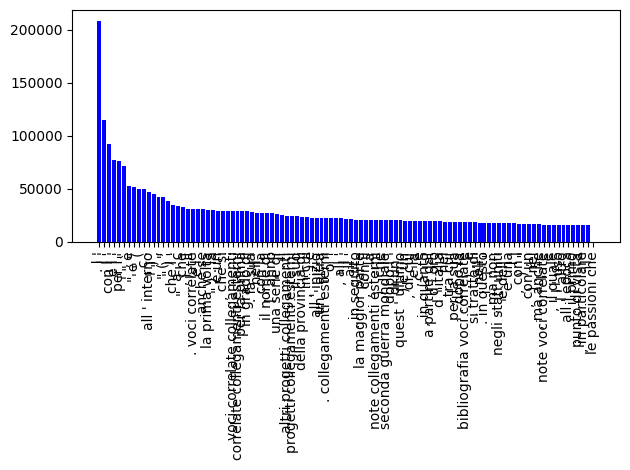

In [34]:
for_hist = wiki_BOW_n3[0:100] + [wiki_BOW_n3[round(len(wiki_BOW_n3)*0.025)]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(for_hist[i][1])

indices = np.arange(len(for_hist))  
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

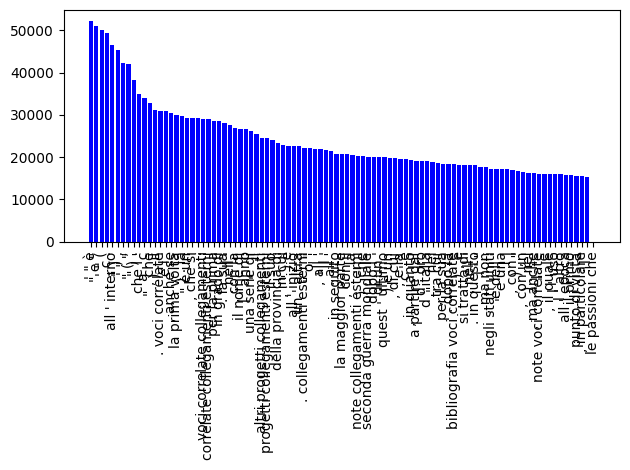

In [35]:
for_hist = wiki_BOW_n3[6:100] + [wiki_BOW_n3[round(len(wiki_BOW_n3)*0.025)]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(for_hist[i][1])

indices = np.arange(len(for_hist))  
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

In [10]:
l_wiki_BOW_n3 = create_BOW_corpus(l_wiki_df, 3)

100%|█████████████████████████████████| 268580/268580 [06:13<00:00, 719.27it/s]


In [22]:
len(l_wiki_BOW_n3)

58251505

In [27]:
l_wiki_BOW_n3[round(len(l_wiki_BOW_n3)*0.1)] #top 10% ('piave , trarre', 3) --> too low
l_wiki_BOW_n3[round(len(l_wiki_BOW_n3)*0.05)] #top 5% ('supplemento ordinario a', 6)
l_wiki_BOW_n3[round(len(l_wiki_BOW_n3)*0.025)] #top 2.5% ('di il buitone', 13) --> ok?

('di il buitone', 13)

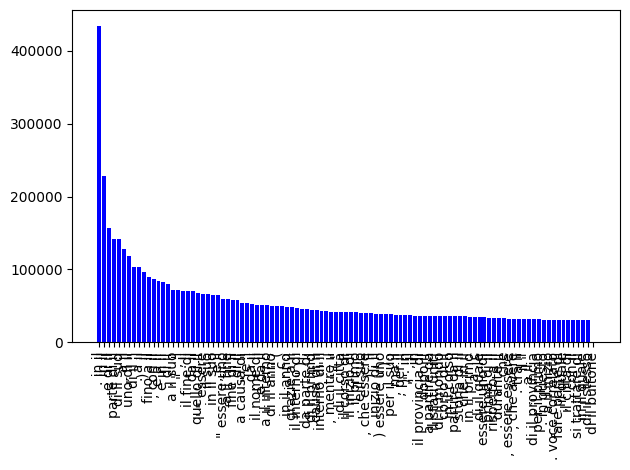

In [31]:
for_hist = l_wiki_BOW_n3[0:100] + [l_wiki_BOW_n3[round(len(l_wiki_BOW_n3)*0.025)]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(for_hist[i][1])

indices = np.arange(len(for_hist))  
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

#Require few hours to run this cell. Run it if necesary. Load from file if exist

s_ner_wiki_BOW_n3 = create_s_BOW_corpus_ner(wiki_df, 3, ["MISC"])

with open("s_ner_wiki_BOW_n3.txt", "w", encoding="utf-8") as file:

    for tup in s_ner_wiki_BOW_n3:
    
        file.write(tup[0]+'| | |'+str(tup[1])+"\n")
        
    file.close()

In [11]:
# Load corpus from file
s_ner_wiki_BOW_n3 = []
lines = []
with open("s_ner_wiki_BOW_n3.txt", "r", encoding="utf-8") as file:
    lines = [line.rstrip() for line in file]

ready = True

for i in range(len(lines)):
    if lines[i] != '':
        st = lines[i]
        if '| | |' not in st and '| | |' in lines[i+1]:
            i+=1
            st = st + "\n" + lines[i]
            ready = True
        elif '| | |' not in st and '| | |' not in lines[i+1]:
            i+=1
            st = st +"\n"+ lines[i]
            ready = False
        elif '| | |' in st:
            ready = True
        else:
            print("FIX CODE!!!")
            raise Exception("incorrect if statement")
        if ready == True:
            try:
                spl = st.rsplit('| | |', 1)
                s_ner_wiki_BOW_n3.append((spl[0],spl[1]))
            except:
                print('Error: ', i, st)

In [32]:
s_ner_wiki_BOW_n3[round(len(s_ner_wiki_BOW_n3)*0.1)] #top 10% ('Solo dalla fine', '3') --> too low
s_ner_wiki_BOW_n3[round(len(s_ner_wiki_BOW_n3)*0.05)] #top 5% ('grande viale che', '6')
s_ner_wiki_BOW_n3[round(len(s_ner_wiki_BOW_n3)*0.025)] #top 2.5% ("momento dell' emissione", '11') --> ok?

("momento dell' emissione", '11')

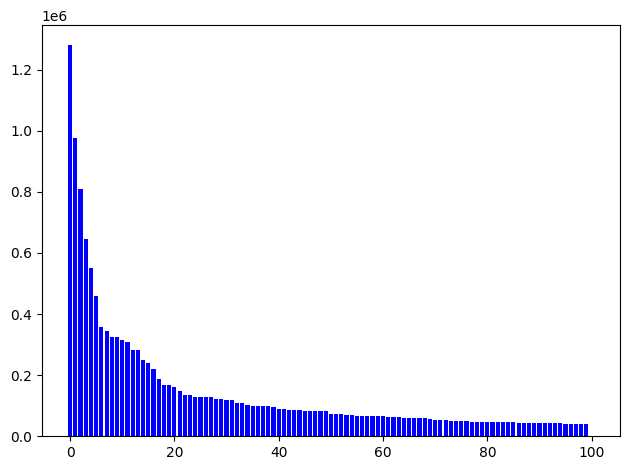

In [28]:
for_hist = s_ner_wiki_BOW_n3[0:100] + [s_ner_wiki_BOW_n3[round(len(s_ner_wiki_BOW_n3)*0.025)]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(int(for_hist[i][1]))

indices = np.arange(len(for_hist))  
plt.bar(indices, frequency, color='b')
#plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

------------

3-Grams

In [12]:
def three_gramm_corpus(text, corpus):
    # predict errors by zero_search function from corpus bow (or bag of n-grams)
    lis = each_word(text)
    text_3_gramm = n_gram(lis, 3)
    result = zero_search(text_3_gramm, corpus)
    result.insert(0, True)
    result.insert(0, True)
    r_or = []
    for i in range(len(result) - 2):
        r_or.append(result[i] or result[i + 1] or result[i + 2])
    return r_or

In [13]:
def three_gramm_lema_corpus(text, corpus):
    # predict errors by zero_search function from corpus bow (or bag of n-grams) with lemma
    doc = nlp(text.lower())
    text = " ".join([token.lemma_ for token in doc])
    lis = each_word(text)
    text_3_gramm = n_gram(lis, 3)
    result = zero_search(text_3_gramm, corpus)
    result.insert(0, True)
    result.insert(0, True)
    r_or = []
    for i in range(len(result) - 2):
        r_or.append(result[i] or result[i + 1] or result[i + 2])
    return r_or

In [14]:
def three_gramm_corpus_ner(text, corpus):
    # predict errors by zero_search function from corpus bow (or bag of n-grams) with spacy tokenizer
    doc = nlp(text)
    ents = []
    for ent in doc.ents:
        if ent.label_ != "MISC":
            ents.append((ent.start, ent.end))
    lis = each_word_s(text)
    text_3_gramm = n_gram(lis, 3)

    result = zero_search(text_3_gramm, corpus)
    result.insert(0, True)
    result.insert(0, True)
    r_or = []
    for i in range(len(result) - 2):
        r_or.append(result[i] or result[i + 1] or result[i + 2])
    return r_or

In [15]:
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    result = three_gramm_corpus(text, wiki_BOW_n3[:round(len(wiki_BOW_n3)*0.025)])
    check = gt_bio(each_word(gt_text), each_word(text))
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'3c_catch'] = catch
    GT_df.loc[index,'3c_extra'] = extra
    GT_df.loc[index,'3c_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_corpus')
    
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    text_words = []
    doc = nlp(text)
    for token in doc:
        text_words.append(token.text)

    check = gt_bio(correct_text_words, text_words)
    
    result = three_gramm_corpus_ner(text, s_ner_wiki_BOW_n3[:round(len(s_ner_wiki_BOW_n3)*0.025)])
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'3sc_ner_catch'] = catch
    GT_df.loc[index,'3sc_ner_extra'] = extra
    GT_df.loc[index,'3sc_ner_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_spacy_corpus')
    
    result = three_gramm_lema_corpus(text, l_wiki_BOW_n3[:round(len(l_wiki_BOW_n3)*0.025)])
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'3lc_catch'] = catch
    GT_df.loc[index,'3lc_extra'] = extra
    GT_df.loc[index,'3lc_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_lema_corpus')



100%|███████████████████████████████████████| 35/35 [1:55:56<00:00, 198.75s/it]

34 two_gramm_lema_corpus


In [39]:
GT_df

,OCR_Text,Ground_True,Checked,3c_catch,3c_extra,3c_miss,3sc_ner_catch,3sc_ner_extra,3sc_ner_miss,3lc_catch,3lc_extra,3lc_miss
0,"MORINI, Segretmio, legge: (C Per gli intervent...","MORINI, Segretario, legge: « Per gli intervent...",True,13.0,192.0,0.0,14.0,173.0,0.0,35.0,174.0,0.0
1,GIORGIO NEBBIA. Solo per ricordare che anche i...,GIORGIO NEBBIA. Solo per ricordare che anche i...,True,2.0,25.0,0.0,2.0,24.0,0.0,2.0,25.0,0.0
2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",True,2.0,19.0,0.0,2.0,19.0,0.0,2.0,20.0,0.0
3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,True,2.0,16.0,0.0,3.0,16.0,0.0,3.0,17.0,0.0
4,due controllate dal gruppo FIAT tramite la Gil...,due controllate dal gruppo FIAT tramite la Gil...,True,3.0,120.0,0.0,7.0,113.0,0.0,12.0,114.0,0.0
5,BATTISTI NI 21208 Sostituzione di un C...,BATTISTINI 21208 Sostituzione di un Co...,True,26.0,36.0,1.0,26.0,35.0,1.0,28.0,35.0,0.0
6,PRESIDENTE . Sono stati presentati i seguenti ...,PRESIDENTE. Sono stati presentati i seguenti e...,True,41.0,429.0,0.0,47.0,409.0,0.0,90.0,410.0,0.0
7,ADELE FACCIO. Noi chiediamo che le disposizion...,ADELE FACCIO. Noi chiediamo che le disposizion...,True,4.0,250.0,0.0,4.0,245.0,0.0,16.0,246.0,0.0
8,"ERNESTO STAJANO, Presidente della IX Commissio...","ERNESTO STAJANO, Presidente della IX Commissio...",True,0.0,55.0,0.0,0.0,52.0,0.0,10.0,53.0,0.0
9,S. 1695. — Senatori MORA ed altri: «Modifiche ...,S. 1695. — Senatori MORA ed altri: «Modifiche ...,True,1.0,81.0,0.0,1.0,78.0,0.0,6.0,79.0,0.0


In [20]:
GT_eval = GT_df.copy()
for index, row in tqdm(GT_eval.iterrows(), total = len(GT_df), position=2):
    eval_row(index, row, '3c', GT_eval)
    eval_row(index, row, '3sc_ner', GT_eval)
    eval_row(index, row, '3lc', GT_eval)



100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 814.04it/s]


In [21]:
print("F05 of 3c:\t",GT_eval['3c_f'].mean())
print("F05 of 3sc_ner:\t",GT_eval['3sc_ner_f'].mean())
print("F05 of 3lc:\t",GT_eval['3lc_f'].mean())

F05 of 3c:	 0.17097033987942126
F05 of 3sc_ner:	 0.15743143568960719
F05 of 3lc:	 0.18456468300530804


As mean of df:

In [22]:
_,_,f = df_calc_prf05(GT_df, '3c')
print("F05 of 3c:\t",f)
_,_,f = df_calc_prf05(GT_df, '3sc_ner')
print("F05 of 3sc_ner:\t",f)
_,_,f = df_calc_prf05(GT_df, '3lc')
print("F05 of 3lc:\t",f)

F05 of 3c:	 0.17479560191711305
F05 of 3sc_ner:	 0.15748645382606324
F05 of 3lc:	 0.17289807128144308


---------
lemma with spacy tokenizer

In [7]:
#!!!!!!! run of this cell require few hours !!! load file of this result if you have it
l_wiki_df = pd.read_csv("lemma_wiki_df.csv")

lem_s_wiki_BOW_n2 = create_s_BOW_corpus(wiki_df, 2) # !!! require few hours !!! load file of this result if you have it

100%|███████████████████████████████████| 269k/269k [4:46:05<00:00, 15.6rows/s]


In [8]:
#Save result of previous cell to file

with open("lem_s_wiki_BOW_n2.txt", "w", encoding="utf-8") as file:

    for tup in lem_s_wiki_BOW_n2:
    
        file.write(tup[0]+'| | |'+str(tup[1])+"\n")
        
    file.close()

In [20]:
# !!!!!!!!! load s_wiki_BOW_n2 from file
lem_s_wiki_BOW_n2 = []
lines = []
with open("lem_s_wiki_BOW_n2.txt", "r", encoding="utf-8") as file:
    lines = [line.rstrip() for line in file]
    
ready = True

for i in range(len(lines)):
    if lines[i] != '':
        st = lines[i]
        if '| | |' not in st and '| | |' in lines[i+1]:
            i+=1
            st = st + "\n" + lines[i]
            ready = True
        elif '| | |' not in st and '| | |' not in lines[i+1]:
            i+=1
            st = st +"\n"+ lines[i]
            ready = False
        elif '| | |' in st:
            ready = True
        else:
            print("FIX CODE!!!")
            raise Exception("incorrect if statement")
        if ready == True:
            try:
                spl = st.rsplit('| | |', 1)
                lem_s_wiki_BOW_n2.append((spl[0].lower(),spl[1]))
            except:
                print('Error: ', i, st)

In [11]:
lem_s_wiki_BOW_n2[round(len(lem_s_wiki_BOW_n2)*0.10)]

('FIDE ha', '7')

In [25]:
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    text_words = []
    doc = nlp(text)
    for token in doc:
        text_words.append(token.text)

    check = gt_bio(correct_text_words, text_words)
    
    result = two_gramm_s_lema_corpus(text, lem_s_wiki_BOW_n2[:round(len(lem_s_wiki_BOW_n2)*0.10)])
    catch, extra, miss = evaluate(check, result)
    GT_df.loc[index,'2lc_catch'] = catch
    GT_df.loc[index,'2lc_extra'] = extra
    GT_df.loc[index,'2lc_miss'] = miss
    clear_output(wait=True)
    print(index, 'two_gramm_lema_corpus')



100%|██████████████████████████████████████████| 35/35 [09:51<00:00, 16.91s/it]

34 two_gramm_lema_corpus


In [28]:
GT_eval = GT_df.copy()
for index, row in tqdm(GT_eval.iterrows(), total = len(GT_df), position=2):
    eval_row(index, row, '2lc', GT_eval)



100%|████████████████████████████████████████| 35/35 [00:00<00:00, 2911.04it/s]


In [29]:
print("F05 of 2lc:\t",GT_eval['2lc_f'].mean())

F05 of 2lc:	 0.14271355040575395


As mean of df:

In [30]:
_,_,f = df_calc_prf05(GT_df, '2lc')
print("F05 of 2lc:\t",f)

F05 of 2lc:	 0.14056358670308441


------------
EXTRA

Log Prob.

In [9]:
import math

In [10]:
wiki_BOW_n2_log = []
for tup in wiki_BOW_n2:
    log = math.log(tup[1])
    wiki_BOW_n2_log.append((tup[0], log))

In [11]:
wiki_BOW_n2_log

[("l '", 14.187438186045664),
 ("dell '", 13.420596590286063),
 ('. il', 13.208724543052373),
 ('" ,', 13.154464576083354),
 ('. la', 13.095881815598089),
 (', che', 13.002254639397595),
 (') ,', 12.843606688284169),
 ("all '", 12.837118332985964),
 (', e', 12.819120866834492),
 (') .', 12.769597924294873),
 (', il', 12.732001637053475),
 ('. nel', 12.612763668564144),
 ('\' "', 12.603125805534066),
 ('" .', 12.577449977727449),
 ("d '", 12.554907435625356),
 (', la', 12.54106879326802),
 (', ma', 12.46787136549213),
 (', in', 12.455616618590858),
 ('" (', 12.367157797660242),
 ('. l', 12.36363179563154),
 ('per la', 12.361682260593676),
 ('di un', 12.323553413285996),
 ("nell '", 12.27660100421971),
 (', con', 12.222083780469157),
 ('. in', 12.201376636519406),
 ('la sua', 12.20031107953946),
 ('e la', 12.145308326456531),
 ("un '", 12.144064254246228),
 ('con la', 12.14283993811331),
 ('" )', 12.080469739227773),
 ('il suo', 12.040631804344253),
 (', "', 12.036570566973465),
 ('. i',

wiki_BOW_n2_log[10000000] # top 50% -> ("' fisiognomonica", 0.0) -> to remove!

wiki_BOW_n2_log[5000000] # top 25% -> ('ripetuti danneggiamenti', 0.69315) -> to remove!

wiki_BOW_n2_log[2000000] # top 10% -> ('allora nessuna', 1.94591)

wiki_BOW_n2_log[200000] # top 1% -> ('lenin e', 4.60517)

In [19]:
#wiki_BOW_n2_log[10000000] # top 50% -> ("' fisiognomonica", 0.0) -> to remove!

#wiki_BOW_n2_log[5000000] # top 25% -> ('ripetuti danneggiamenti', 0.69315) -> to remove!

#wiki_BOW_n2_log[2000000] # top 10% -> ('allora nessuna', 1.94591)

wiki_BOW_n2_log[200000] # top 1% -> ('lenin e', 4.60517)

('lenin e', 4.605170185988092)

In [15]:
for_hist = wiki_BOW_n2_log[0:10] + [wiki_BOW_n2_log[2000000]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(for_hist[i][1])

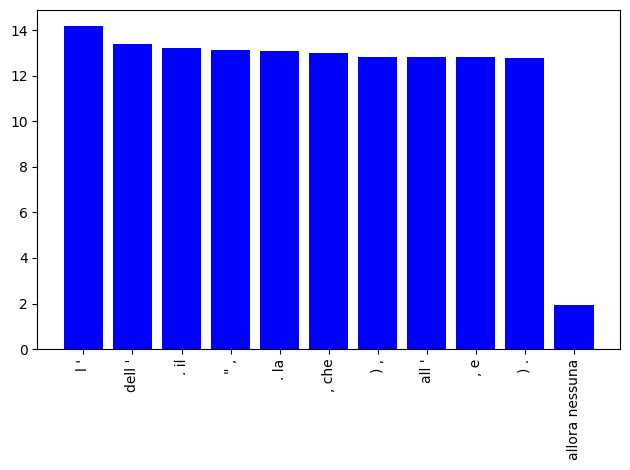

In [16]:
indices = np.arange(len(for_hist))
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

In [21]:
for_hist = wiki_BOW_n2_log[50:100] + [wiki_BOW_n2_log[2000000]]
word = []
frequency = []

for i in range(len(for_hist)):
    word.append(for_hist[i][0])
    frequency.append(for_hist[i][1])

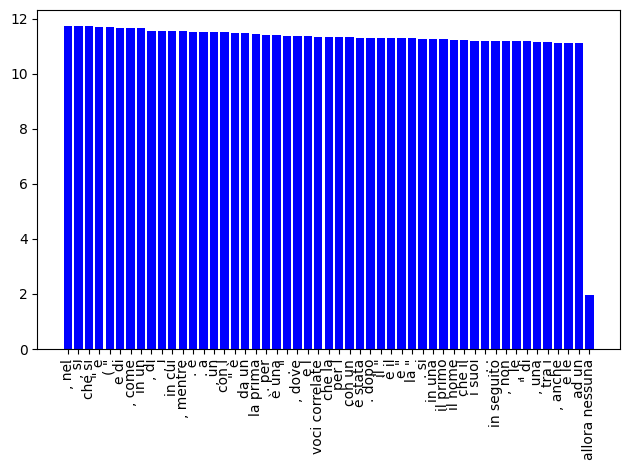

In [22]:
indices = np.arange(len(for_hist))
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

In [11]:
small_words = []
for words in wiki_BOW_n2[:2000000]:
    if len(words[0]) <= 7:
        small_words.append(words[0])
len(small_words)

242889

In [13]:
small_words = []
for words in wiki_BOW_n2[:2000000]:
    if len(words[0]) <= 6:
        small_words.append(words[0])
len(small_words)

134125

In [14]:
small_words = []
for words in wiki_BOW_n2[:2000000]:
    if len(words[0]) <= 5:
        small_words.append(words[0])
len(small_words)

62644

To Delete

In [14]:
def two_gramm_lema_corpus_words(text, corpus):
    # predict errors by zero_search function from corpus bow (or bag of n-grams) with lemma
    doc = nlp(text.lower())
    text = " ".join([token.lemma_ for token in doc])
    print(text)
    text_2_gramm = two_gram(text)
    result = zero_search(text_2_gramm, corpus)
    result.insert(0, True)
    r_or = []
    for i in range(len(result) - 1):
        r_or.append(result[i] or result[i + 1])
    return r_or

In [20]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True'] 
    
correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

text_words = []
doc = nlp(text)
for token in doc:
    text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

result = two_gramm_lema_corpus_words(text, l_wiki_BOW_n2[:1500000])
catch, extra, miss = evaluate(check, result)
print(index, 'two_gramm_lema_corpus')

calasso . il onorevole Vanoni affermare che avere fare condurre il inchiesta e che il ’ « inea 1 ) avere fare proposta per il risoluzione di il crisi di il tabacchicoltura . non sapere che essere s ta ta   pubblicare il relazione generale . lo apprendere adesso da   lei , m a   io avere avere occasione di leggere , dicevo testè , quanto avere scrivere il prorii , di il universita di perugia , e il Rossi doria su il tabacchicoltura   di il Italia centrale e meridionale e su il problema connesso . non dimenticare , onorevole ministro , che questo due professore , insieme con il altro incaricato di dirigere il inchiesta per il Nord Italia ( di cui mi sfuggere il nome ) , essere essere di accordo in il dichiarare che il coltu ra   di il tabacco in il valle di il Brenta e in il capo di leuca , dove vi essere uno formicaio umano di povero gente eternamente disoccupato , costringere a   emigrare ogni anno a matera , a chieti , a viterbo , fino a grosseto , da dove iitornano piii povero ancora

 57%|████████████████████               | 2473/4327 [03:15<01:39, 18.64gramm/s]

KeyboardInterrupt: 

 57%|████████████████████               | 2473/4327 [03:31<01:39, 18.64gramm/s]

In [21]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True'] 
    
correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

text_words = []
doc = nlp(text)
for token in doc:
    text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

result = two_gramm_lema_corpus_words(gt_text, l_wiki_BOW_n2[:1500000])
catch, extra, miss = evaluate(check, result)
print(index, 'two_gramm_lema_corpus')

calasso . il onorevole Vanoni affermare che avere fare condurre il inchiesta e che il ’ « inea » avere fare proposta per il risoluzione di il crisi di il tabacchicoltura . non sapere che essere essere pubblicare il relazione generale . lo apprendere adesso da lei , ma io avere avere occasione di leggere , dicevo testè , quanto avere scrivere il prone , di il università di perugia , e il Rossi doria su il tabacchicoltura di il Italia centrale e meridionale e su il problema connesso . non dimenticare , onorevole ministro , che questo due professore , insieme con il altro incaricato di dirigere il inchiesta per il Nord Italia ( di cui mi sfuggere il nome ) , essere essere di accordo in il dichiarare che il coltura di il tabacco in il valle di il Brenta e in il capo di leuca , dove vi essere uno formicaio umano di povero gente eternamente disoccupato , costringere a emigrare ogni anno a matera , a chieti , a viterbo , fino a grosseto , da dove ritornare più povero ancora e malato , rappres

  0%|                                     | 12/4249 [00:01<05:29, 12.85gramm/s]

KeyboardInterrupt: 

  0%|▏                                    | 16/4249 [00:15<05:29, 12.85gramm/s]

------------
synthetic data generation

list of errors for EliCoDe

In [16]:
text = GT_df.iloc[31]['OCR_Text']
gt_text = GT_df.iloc[31]['Ground_True']    

result, text_words = elidoce_spacy_pred(text)

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)

check = gt_bio(correct_text_words, text_words)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\Anton\anaconda3\lib\site-packages\ipykernel\kernela

In [30]:
gt_bio(correct_text_words, text_words, print_difference = True)

0 | 0 | MORINI | MORINI | True
1 | 1 | , | , | True
2 | 2 | Segretario | Segretmio | False
3 | 3 | , | , | True
4 | 4 | legge | legge | True
5 | 5 | : | : | True
6 | 7 | « | ( _ C | False
7 | 8 | Per | Per | True
8 | 9 | gli | gli | True
9 | 10 | interventi | interventi | True
10 | 11 | di | di | True
11 | 12 | competenza | competenza | True
12 | 13 | del | del | True
13 | 14 | Ministero | Ministero | True
14 | 15 | dei | dei | True
15 | 16 | lavori | lavori | True
16 | 17 | pubblici | pubblici | True
17 | 18 | previsti | previsti | True
18 | 19 | dalla | dalla | True
19 | 20 | legge | legge | True
20 | 21 | 14 | 14 | True
21 | 22 | marzo | marzo | True
22 | 23 | 1968 | 1968 | True
23 | 24 | , | , | True
24 | 25 | n. | n. | True
25 | 26 | 292 | 292 | True
26 | 27 | , | , | True
27 | 28 | è | è | True
28 | 29 | autorizzata | autorizzata | True
29 | 30 | la | la | True
30 | 31 | spesa | spesa | True
31 | 32 | di | di | True
32 | 33 | lire | lire | True
33 | 34 | 3.000 | 3.000 | True
34 |

[True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru

In [19]:
print(gt_bio_diff(correct_text_words, text_words))

18 | 19 | » | 1 _ ) | False
33 | 35 | stata | s | False
34 | 37 | stata | sta _ ta | False
46 | 50 | ma | m _ a | False
61 | 65 | Proni | Prorii | False
64 | 68 | università | universita | False
125 | 130 | coltura | coltu _ ra | False
170 | 175 | ritornano | iitornano | False
171 | 176 | più | piii | False
184 | 189 | può | pub | False
193 | 198 | Vanoni | Vaiioni | False
219 | 224 | afferinato | af€erinato | False
246 | 251 | remunerazione | reiiiuiierazi«ne | False
264 | 270 | tutto | tu | False
265 | 272 | tutto | tut _ to | False
291 | 299 | tutta | t | False
291 | 300 | tutta | tu | False
291 | 301 | tutta | tut | False
292 | 303 | tutta | tutt _ a | False
312 | 324 | stato | : _ stato | False
330 | 342 | del | dei | False
413 | 425 | miIiardi | miIhrdi | False
460 | 472 | allargare | allargarle | False
498 | 511 | Costituzione | Cos | False
499 | 513 | Costituzione | Costi _ tuzione | False
571 | 586 | » | ) _ ) | False
592 | 608 | tutti | tiitt _ , | False
594 | 611 | cittadini

In [18]:
def gt_bio_diff(gt_text, text):
    check = []
    i = 0
    j = 0
    is_extra_space = False
    extra_word = ''
    while i < len(gt_text) or j < len(text):
        if i < len(gt_text):
            left = replace_apostrophe(gt_text[i])
        else:
            left = "_"
        if j < len(text):
            right = replace_apostrophe(text[j])
            if is_extra_space:
                right = extra_word + right
        else:
            right = "_"
        if left == right:
            if left == "_" and (i >= len(gt_text) or j >= len(text)):
                continue
            correct = True
            if is_extra_space:
                correct = False
            is_extra_space = False
        else:
            correct = False
            is_extra_space = False # False in most cases, if True will overwrite in specific case
            if (j+2)<len(text) and (i+1)<len(gt_text) and replace_apostrophe(gt_text[i+1]) == replace_apostrophe(text[j+2]):
                 # skip 1 entry of text_words as it's false
                right = right + ' _ ' + replace_apostrophe(text[j+1])
                j+=1
            elif (j)<len(text) and (i+1)<len(gt_text) and replace_apostrophe(gt_text[i+1]) == replace_apostrophe(text[j]):
                j-=1
                correct = True
            elif (j+1)<len(text) and left.startswith(right) and left.startswith(right + replace_apostrophe(text[j+1])): # pa ro la
                is_extra_space = True
                extra_word = right
                i -= 1
            elif (j+1)<len(text) and not left.startswith(right) and left.startswith(replace_apostrophe(text[j+1])): # _ pa rola
                i -= 1
            elif (j+1)<len(text) and left.startswith(right) and text[j+1] == ' ' and left.startswith(right + replace_apostrophe(text[j+2])): # pa _ ro la
                extra_word = right
                j+=1
                i -= 1
            elif (j+2)<len(text) and not left.startswith(right) and (replace_apostrophe(text[j+1]) in left or replace_apostrophe(text[j+2]) in left): # I ~ ro la
                i -= 1
                is_extra_space = True
                extra_word = right
            elif (j+1)<len(text) and (i+1)<len(gt_text) and replace_apostrophe(gt_text[i+1]) == replace_apostrophe(text[j+1]):
                pass
        if not correct:
            print(i,"|", j,"|", left, "|", right, "|", correct)
            check.append((left, right))
        i += 1
        j += 1
    return check

In [32]:
errors = []
for index, row in tqdm(GT_df.iterrows(), total = len(GT_df), position=2):
    text = row['OCR_Text']
    gt_text = row['Ground_True']    
    
    result, text_words = elidoce_spacy_pred(text)
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)

    check = gt_bio_diff(correct_text_words, text_words)
    errors = errors + check

    clear_output(wait=True)
    print(index, 'elicode_spacy')



100%|██████████████████████████████████████████| 35/35 [15:04<00:00, 25.83s/it]

34 elicode_spacy


In [33]:
errors

[('Segretario', 'Segretmio'),
 ('«', '( _ C'),
 ('è', 'B'),
 ("l'aumentata", "' _ aumentata"),
 ('di', "' _ di"),
 ('Ordinario', 'ordinario'),
 ('di', '.di'),
 ('Ordinario', 'ordinario'),
 ('Il', 'I1'),
 ('»', 'n.'),
 ('È', 'B'),
 ('indipendente', 'indi _ pendente'),
 ('Presidente', 'Presi _ dente'),
 ('della', 'del _ la'),
 ('di', 'd _ i'),
 ("l'", "l _ '"),
 ("l'", "l _ '"),
 ('leggeri', 'legeri'),
 ('BATTISTINI', 'BATTISTI'),
 ('BATTISTINI', 'BATTISTINI'),
 ('dipendente', 'di _ pendente'),
 ('delle', 'e'),
 ('poste', 'telecomunicazioni'),
 ('poste', 'telecomunicazionidelle'),
 ('e', '('),
 ('delle', '2941'),
 ('telecomunicazioni', ')'),
 ('(', '.'),
 ('2941', '.'),
 ('2941', '.2119'),
 ('2941', '.21199'),
 (')', '21208'),
 ('.', ','),
 ('.', '21219'),
 ('21199', 'La'),
 ('21208', 'seduta'),
 (',', 'comincia'),
 ('21219', 'alle'),
 ('La', '17'),
 ('seduta', '.'),
 ('comincia', '_'),
 ('alle', '_'),
 ('17', '_'),
 ('.', '_'),
 ('consiglio', 'consigli _ o'),
 ('del', 'de _ l'),
 ('di',

ar -> m
ia -> h
en -> m
« -> (C, ((
» -> J), )). 1), D
è -> B, 6
é -> b
È -> B
l -> 1, I
a -> o, n, i1
vv -> w
à -> h, a, 8, B, ò, i
i -> e, 1, à
e -> b, c
o -> q, «, 0, u, a
h -> JI, li
Z -> l
d -> cl
m -> n, iii, rn, in
M -> hf
t -> fp
n -> ri, ii
r -> i
ù -> ii, i1
ò -> b
f -> €, l
u -> ii, ti, ù
9 -> 0
8 -> a
2 -> Z
1 -> l

miss letter (any + spaces)

extra: ', _ (space), ., ,, 

In [49]:
errors_list = []
errors_list.append(['ar','m'])
errors_list.append(['ia', 'h'])
errors_list.append(['en', 'm'])
errors_list.append(['«', '(C', '(('])
errors_list.append(['»', 'J)', '))', '1)', 'D'])
errors_list.append(['è', 'b', '6'])
errors_list.append(['é', 'b'])
errors_list.append(['l', '1', 'I'])
errors_list.append(['a', 'o'])
#errors_list.append(['a', 'o', 'n', 'i1'])
errors_list.append(['vv', 'w'])
errors_list.append(['à', 'h', 'a', '8', 'b', 'ò', 'i'])
errors_list.append(['i', 'e', '1', 'à'])
errors_list.append(['e', 'b','c'])
errors_list.append(['o', 'q', '0', 'u', 'a'])
errors_list.append(['h', 'ji','li'])
#errors_list.append(['Z', 'l'])
errors_list.append(['d', 'cl'])
errors_list.append(['m', 'n', 'iii', 'rn', 'in'])
#errors_list.append(['M', 'hf'])
errors_list.append(['t', 'fp'])
errors_list.append(['n', 'ri','ii'])
errors_list.append(['r', 'i'])
errors_list.append(['ù', 'ii', 'i1', 'u'])
errors_list.append(['ò', 'b', 'o'])
errors_list.append(['f', '€', 'l'])
errors_list.append(['u', 'ii', 'ti', 'ù'])
errors_list.append(['9', '0', 'q'])
errors_list.append(['8', 'a', 'b'])
errors_list.append(['2', 'z'])
errors_list.append(['1', 'l', 'i'])

In [110]:
graph = defaultdict(set)
for errs in errors_list:
    ver1 = errs[0]
    for e in errs[1:]:
        ver2 = e
        graph[ver1].add(ver2)
        graph[ver2].add(ver1)
graph

defaultdict(set,
            {'ar': {'m'},
             'm': {'ar', 'en', 'iii', 'in', 'n', 'rn'},
             'ia': {'h'},
             'h': {'ia', 'ji', 'li', 'à'},
             'en': {'m'},
             '«': {'((', '(C'},
             '(C': {'«'},
             '((': {'«'},
             '»': {'))', '1)', 'D', 'J)'},
             'J)': {'»'},
             '))': {'»'},
             '1)': {'»'},
             'D': {'»'},
             'è': {'6', 'b'},
             'b': {'8', 'e', 'à', 'è', 'é', 'ò'},
             '6': {'è'},
             'é': {'b'},
             'l': {'1', 'I', 'f'},
             '1': {'i', 'l'},
             'I': {'l'},
             'a': {'8', 'o', 'à'},
             'o': {'0', 'a', 'q', 'u', 'ò'},
             'vv': {'w'},
             'w': {'vv'},
             'à': {'8', 'a', 'b', 'h', 'i', 'ò'},
             '8': {'a', 'b', 'à'},
             'ò': {'b', 'o', 'à'},
             'i': {'1', 'e', 'r', 'à'},
             'e': {'b', 'c', 'i'},
             'c': {'e'},
    

In [113]:
def return_vertices_in_depth(depth, max_depth, graph, ver):
    lis = graph[ver]
    l = graph[ver].copy()
    if depth+1 < max_depth:
        for el in lis:
            l.update(return_vertices_in_depth(depth+1, max_depth, graph, el))
    return l

In [116]:
errors_dist_3 = defaultdict(set)
keys = list(graph.keys())
for ver in keys:
    lis = graph[ver].copy()
    l = lis.copy()
    for el in lis:
        l.update(return_vertices_in_depth(0, 3, graph, el))
    errors_dist_3[ver].update(l)
errors_dist_3

defaultdict(set,
            {'ar': {'ar',
              'en',
              'ii',
              'iii',
              'in',
              'm',
              'n',
              'ri',
              'rn',
              'u',
              'ù'},
             'm': {'ar',
              'en',
              'i1',
              'ii',
              'iii',
              'in',
              'm',
              'n',
              'o',
              'ri',
              'rn',
              'ti',
              'u',
              'ù'},
             'ia': {'1',
              '8',
              'a',
              'b',
              'e',
              'h',
              'i',
              'ia',
              'ji',
              'li',
              'o',
              'r',
              'à',
              'è',
              'é',
              'ò'},
             'h': {'0',
              '1',
              '6',
              '8',
              'a',
              'b',
              'c',
              'e',
      

-----

In [45]:
error_sets = []
for errs in errors_list:
    is_in = False
    if error_sets == []:
        error_sets.append(set(errs))
        continue
    for s in error_sets:
        for e in errs:
            if e in s:
                is_in = True
                s.update(set(errs))
    if not is_in:
        error_sets.append(set(errs))
        
error_sets

[{'ar', 'en', 'i1', 'ii', 'iii', 'in', 'm', 'n', 'ri', 'rn', 'ti', 'u', 'ù'},
 {'0',
  '1',
  '8',
  '9',
  'B',
  'JI',
  'a',
  'b',
  'c',
  'e',
  'h',
  'i',
  'i1',
  'ia',
  'ii',
  'l',
  'li',
  'o',
  'q',
  'r',
  'ti',
  'u',
  'à',
  'ò',
  'ù'},
 {'((', '(C', '«'},
 {'))', '1)', 'D', 'J)', '»'},
 {'0',
  '1',
  '6',
  '8',
  '9',
  'B',
  'JI',
  'a',
  'b',
  'c',
  'e',
  'h',
  'i',
  'i1',
  'ii',
  'l',
  'li',
  'o',
  'q',
  'r',
  'ti',
  'u',
  'È',
  'à',
  'è',
  'ò',
  'ù'},
 {'b', 'c', 'e', 'o', 'é', 'ò'},
 {'1', 'I', 'b', 'c', 'e', 'f', 'i', 'l', 'o', 'r', 'à', 'ò', '€'},
 {'0',
  '1',
  '8',
  '9',
  'B',
  'JI',
  'a',
  'b',
  'c',
  'e',
  'h',
  'i',
  'i1',
  'ii',
  'l',
  'li',
  'o',
  'q',
  'r',
  'ti',
  'u',
  'à',
  'ò',
  'ù'},
 {'vv', 'w'},
 {'cl', 'd'},
 {'M', 'hf'},
 {'fp', 't'},
 {'2', 'Z'}]

In [46]:
ready = True
check_set = set()

for s in error_sets:
    for element in s:
        if element in check_set:
            ready = False
            break
    check_set.update(s)

while not ready:
    index = [False]*len(error_sets)
    for i, s in enumerate(error_sets):
        if i == 0:
            continue
        for element in s:
            for j in range(i):
                if element in error_sets[j]:
                    index[i] = True
                    error_sets[j].update(s)
                    break
            if index[i]:
                break
                
    if True in index:
        for i, e in reversed(list(enumerate(index))):
            if e:
                del error_sets[i]
                
    check_set = set()
    ready = True
    for s in error_sets:
        for element in s:
            if element in check_set:
                ready = False
                break
        check_set.update(s)

error_sets

[{'0',
  '1',
  '6',
  '8',
  '9',
  'B',
  'I',
  'JI',
  'a',
  'ar',
  'b',
  'c',
  'e',
  'en',
  'f',
  'h',
  'i',
  'i1',
  'ia',
  'ii',
  'iii',
  'in',
  'l',
  'li',
  'm',
  'n',
  'o',
  'q',
  'r',
  'ri',
  'rn',
  'ti',
  'u',
  'È',
  'à',
  'è',
  'é',
  'ò',
  'ù',
  '€'},
 {'((', '(C', '«'},
 {'))', '1)', 'D', 'J)', '»'},
 {'vv', 'w'},
 {'cl', 'd'},
 {'M', 'hf'},
 {'fp', 't'},
 {'2', 'Z'}]

by groups:

è, B, b, 6, é, È, à, a, h, 8, ò, i, e, 1, c

------------

In [33]:
elicode_init.end() #sys.path.remove(self.path)